In [1]:
import torch
import random as rd

torch.manual_seed(0)
rd.seed(0)

from typing import Tuple, Optional
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
step = .005
max_t = 5
M = torch.ones(3)
G = 1
max_magnitude = 3

In [3]:
def show(x, y):
  
    plt.figure(figsize = (8, 8))
    for i, c in zip(range(3), "gbr"):
        plt.plot(x[:, i], y[:, i], color=c)
        plt.scatter(x[0, i], y[0, i], color=c)
    plt.grid()
    plt.xlim(x.min() - 0.2, x.max() + 0.2)
    plt.ylim(y.min() - 0.2, y.max() + 0.2)
    plt.show()

In [4]:
t = torch.arange(start=0, end=max_t, step=step)

In [5]:
def setup(n: int) -> torch.Tensor:
    
    theta = torch.rand(n) * torch.pi + torch.pi / 2
    r = torch.rand(n)

    x1 = torch.stack((torch.ones(n), torch.zeros(n)), dim=1)
    x2 = torch.stack((r * torch.cos(theta), r * torch.sin(theta)), dim=1)
    x3 = - torch.add(x1, x2)
    return torch.stack((x1, x2, x3), dim=1)

In [6]:
def compute_acceleration(x: torch.Tensor, 
                         y: torch.Tensor, 
                         ax: torch.Tensor, 
                         ay: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

    for i in range(3):
        dx = (x[:, i] - x.T).T
        dy = (y[:, i] - y.T).T
        d = torch.sqrt(dx ** 2 + dy ** 2) ** 3
        
        ax[:, :, i] = torch.nan_to_num(-dx * M * G / d)
        ay[:, :, i] = torch.nan_to_num(-dy * M * G / d)
        
    ax_tot = torch.sum(ax, axis=1)
    ay_tot = torch.sum(ay, axis=1)
    return ax_tot, ay_tot

def compute_acceleration1(positions, acceleration):
    
    for i in range(3):
        dxy = (positions[:, i].unsqueeze(-1) - positions.mT).mT
        d = torch.norm(dxy, dim=-1, keepdim=True)
        acceleration[:, i] = torch.nan_to_num(-dxy * M * G / d)
    return torch.sum(acceleration, dim=2)

In [7]:
def clamp_magnitude(v):
    magnitudes = torch.norm(v, dim=-1)
    large = magnitudes > max_magnitude
    if large.any():
        v[large] = v[large] * max_magnitude / magnitudes[large].unsqueeze(-1)
    return v

In [8]:
def run_euler(n: int) -> Tuple[torch.Tensor, torch.Tensor]:
    
    positions = torch.zeros(n, len(t), 3, 2) # simulation_id x t x body_id x (x,y)
    velocities = torch.zeros(n, 3, 2) # simulation_id x body_id x (x,y)
    acceleration = torch.zeros(n, 3, 3, 2) # simulation_id x body_id x other_body_id x (x,y) 
    
    positions[:, 0] = setup(n)
    
    for i in range(len(t) - 1):
        #total_acceleration = compute_acceleration1(positions[:, i], acceleration)
        ax_tot, ay_tot = compute_acceleration(positions[:, i, :, 0], positions[:, i, :, 1],
                                              acceleration[..., 0], acceleration[..., 1])
        positions[:, i+1] = positions[:, i] + velocities * step
        if i == 0: print(ax_tot, ay_tot)
        velocities = clamp_magnitude(velocities + torch.stack((ax_tot * step, ay_tot * step), dim=-1))
    
    return positions

In [9]:
p = run_euler(2)

tensor([[-1.1177, -0.6321,  1.7498],
        [-1.1071, -0.5194,  1.6265]]) tensor([[ 0.0007, -0.0045,  0.0039],
        [-0.0616,  0.3994, -0.3378]])


In [10]:
p.shape

torch.Size([2, 1000, 3, 2])

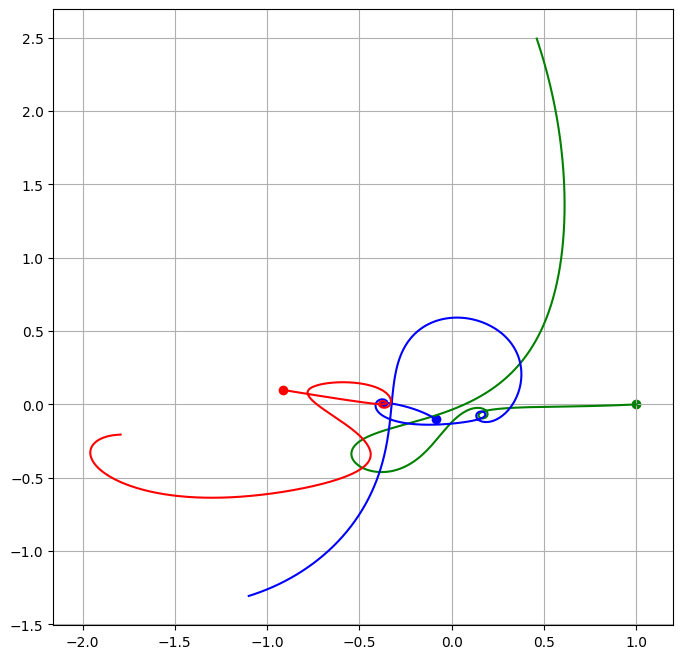

In [11]:
show(p[1, :, :, 0], p[1, :, :, 1])